In [2]:
import os

from tqdm import tqdm
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import scipy.optimize

import torch
from torch import nn
from torch.cuda.amp import autocast
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.models

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '6'

In [4]:
def save_model(model, i):
    sd = model.state_dict()
    torch.save(model.state_dict(), '%s.pt' % i)

def load_model(model, i):
    sd = torch.load('%s.pt' % i)
    model.load_state_dict(sd)

## Load data & models

In [5]:
from ffcv.pipeline.operation import Operation
from ffcv.loader import Loader, OrderOption
from ffcv.transforms import ToTensor, ToDevice, Squeeze, NormalizeImage, \
    RandomHorizontalFlip, ToTorchImage
from ffcv.fields.rgb_image import CenterCropRGBImageDecoder, \
    RandomResizedCropRGBImageDecoder
from ffcv.fields.basics import IntDecoder

device = torch.device('cuda')

IMAGENET_MEAN = np.array([0.485, 0.456, 0.406])
IMAGENET_STD = np.array([0.229, 0.224, 0.225])
denormalize = T.Normalize(-IMAGENET_MEAN/IMAGENET_STD, 1/IMAGENET_STD)

def get_loader(name, aug=False):
    dset_path = '/persist/kjordan/data_image/ffcv_imagenet/%s.ffcv' % name
    
    res = 224 if aug else 256
    crop_ratio = 224/256 if aug else 1.0
    
    image_pipeline = (([
        RandomResizedCropRGBImageDecoder((res, res)),
        RandomHorizontalFlip(),
    ] if aug else [
        CenterCropRGBImageDecoder((res, res), ratio=crop_ratio),
    ])+[
        ToTensor(),
        ToDevice(device, non_blocking=True),
        ToTorchImage(),
        NormalizeImage(IMAGENET_MEAN*255, IMAGENET_STD*255, np.float16),
    ])

    label_pipeline = [
        IntDecoder(),
        ToTensor(),
        Squeeze(),
        ToDevice(device, non_blocking=True)
    ]

    loader = Loader(dset_path,
                    batch_size=200,
                    num_workers=4,
                    order=OrderOption.SEQUENTIAL,
                    drop_last=False,
                    pipelines={
                        'image': image_pipeline,
                        'label': label_pipeline
                    },
                    distributed=False)
    return loader
    
train_loader = train10k_aug_loader = get_loader('train5k', aug=True)
train5k_loader = get_loader('train5k')
val5k_loader = get_loader('val5k')
val50k_loader = get_loader('val')

In [6]:
# evaluates accuracy
def evaluate(model, loader=val5k_loader, tta=False):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad(), autocast():
        for inputs, labels in loader:
            outputs = model(inputs.cuda())
            if tta:
                outputs = (outputs + model(inputs.flip(3)))/2
            pred = outputs.argmax(dim=1)
            correct += (labels.cuda() == pred).sum().item()
            total += len(labels)
    return correct / total

# evaluates acc and loss
def evaluate2(model, loader=val5k_loader, tta=True):
    model.eval()
    losses = []
    correct = 0
    total = 0
    with torch.no_grad(), autocast():
        for inputs, labels in loader:
            outputs = model(inputs.cuda())
            if tta:
                outputs = (outputs + model(inputs.flip(3)))/2
            pred = outputs.argmax(dim=1)
            correct += (labels.cuda() == pred).sum().item()
            total += len(labels)
            loss = F.cross_entropy(outputs, labels.cuda())
            losses.append(loss.item())
    return correct / total, np.array(losses).mean()

def full_eval(model):
    tr_acc, tr_loss = evaluate2(model, loader=train5k_loader)
    te_acc, te_loss = evaluate2(model, loader=val5k_loader)
    return (100*tr_acc, tr_loss, 100*te_acc, te_loss)

865


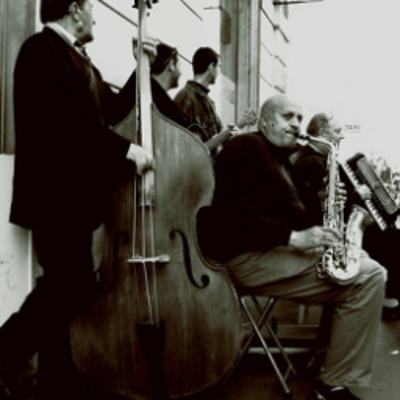

In [7]:
images, labels = next(iter(train5k_loader))
print(labels[1].item())

img_a = denormalize(images[0]).float()
img_a = img_a.permute(1, 2, 0)
img_a = img_a.cpu().numpy()
img_a = (255 * img_a).astype(np.uint8)
Image.fromarray(img_a).resize((400, 400))

In [8]:
def resnet50():
    model = torchvision.models.resnet50(pretrained=False)
    return model.cuda().eval()

def get_blocks(net):
    return nn.Sequential(nn.Sequential(net.conv1, net.bn1, net.relu, net.maxpool),
                         *net.layer1, *net.layer2, *net.layer3, *net.layer4)

def add_junctures(net):
    net1 = resnet50()
    net1.load_state_dict(net.state_dict())
    blocks = get_blocks(net1)[1:]
    for block in blocks:
        if block.downsample is not None:
            continue
        planes = len(block.bn3.weight)
        shortcut = nn.Conv2d(planes, planes, kernel_size=1, stride=1, padding=0, bias=False)
        shortcut.weight.data[:, :, 0, 0] = torch.eye(planes)
        block.downsample = shortcut
    return net1.cuda().eval()

### Matching code

In [8]:
# given two networks net0, net1 which each output a feature map of shape NxCxWxH
# this will reshape both outputs to (N*W*H)xC
# and then compute a CxC correlation matrix between the outputs of the two networks
def run_corr_matrix(net0, net1, epochs=1, loader=train_loader):
    n = epochs*len(loader)
    mean0 = mean1 = std0 = std1 = None
    with torch.no_grad():
        net0.eval()
        net1.eval()
        for _ in range(epochs):
            for i, (images, _) in enumerate(tqdm(loader)):
                img_t = images.float().cuda()
                out0 = net0(img_t)
                out0 = out0.reshape(out0.shape[0], out0.shape[1], -1).permute(0, 2, 1)
                out0 = out0.reshape(-1, out0.shape[2]).double()

                out1 = net1(img_t)
                out1 = out1.reshape(out1.shape[0], out1.shape[1], -1).permute(0, 2, 1)
                out1 = out1.reshape(-1, out1.shape[2]).double()

                mean0_b = out0.mean(dim=0)
                mean1_b = out1.mean(dim=0)
                std0_b = out0.std(dim=0)
                std1_b = out1.std(dim=0)
                outer_b = (out0.T @ out1) / out0.shape[0]

                if i == 0:
                    mean0 = torch.zeros_like(mean0_b)
                    mean1 = torch.zeros_like(mean1_b)
                    std0 = torch.zeros_like(std0_b)
                    std1 = torch.zeros_like(std1_b)
                    outer = torch.zeros_like(outer_b)
                mean0 += mean0_b / n
                mean1 += mean1_b / n
                std0 += std0_b / n
                std1 += std1_b / n
                outer += outer_b / n

    cov = outer - torch.outer(mean0, mean1)
    corr = cov / (torch.outer(std0, std1) + 1e-4)
    return corr

In [9]:
def get_layer_perm1(corr_mtx):
    corr_mtx_a = corr_mtx.cpu().numpy()
    corr_mtx_a = np.nan_to_num(corr_mtx_a)
    row_ind, col_ind = scipy.optimize.linear_sum_assignment(corr_mtx_a, maximize=True)
    assert (row_ind == np.arange(len(corr_mtx_a))).all()
    perm_map = torch.tensor(col_ind).long()
    return perm_map

# returns the channel-permutation to make layer1's activations most closely
# match layer0's.
def get_layer_perm(net0, net1):
    corr_mtx = run_corr_matrix(net0, net1)
    return get_layer_perm1(corr_mtx)

In [10]:
def permute_output(perm_map, conv, bn=None):
    pre_weights = [conv.weight]
    if bn is not None:
        pre_weights.extend([bn.weight, bn.bias, bn.running_mean, bn.running_var])
    for w in pre_weights:
        w.data = w[perm_map]

def permute_input(perm_map, conv):
    w = conv.weight
    w.data = w[:, perm_map, :, :]

## Match neurons

In [11]:
model = resnet50()

sd = torch.load('/persist/kjordan/notebooks/permutations/imagenet/4b68ff5c_e300.pt')
model.load_state_dict({k[len('module.'):]: v for k, v in sd.items()})
save_model(model, 'imagenet/resnet50_v1')

sd = torch.load('/persist/kjordan/notebooks/permutations/imagenet/fe1b05ad_e300.pt')
model.load_state_dict({k[len('module.'):]: v for k, v in sd.items()})
save_model(model, 'imagenet/resnet50_v2')

In [12]:
model0 = resnet50()
model1 = resnet50()
load_model(model0, 'imagenet/resnet50_v1')
load_model(model1, 'imagenet/resnet50_v2')

model0 = add_junctures(model0)
model1 = add_junctures(model1)
save_model(model0, 'imagenet/resnet50j_v1')
save_model(model1, 'imagenet/resnet50j_v2')

blocks0 = get_blocks(model0)
blocks1 = get_blocks(model1)
evaluate(model0), evaluate(model1)

(0.7618, 0.7584)

### intrablock channels

In [24]:
for k in range(1, len(blocks1)):
    block0 = blocks0[k]
    block1 = blocks1[k]
    subnet0 = nn.Sequential(blocks0[:k],
                            block0.conv1, block0.bn1, block0.relu)
    subnet1 = nn.Sequential(blocks1[:k],
                            block1.conv1, block1.bn1, block1.relu)
    perm_map = get_layer_perm(subnet0, subnet1)
    permute_output(perm_map, block1.conv1, block1.bn1)
    permute_input(perm_map, block1.conv2)
    
    subnet0 = nn.Sequential(blocks0[:k],
                            block0.conv1, block0.bn1, block0.relu,
                            block0.conv2, block0.bn2, block0.relu)
    subnet1 = nn.Sequential(blocks1[:k],
                            block1.conv1, block1.bn1, block1.relu,
                            block1.conv2, block1.bn2, block1.relu)
    perm_map = get_layer_perm(subnet0, subnet1)
    permute_output(perm_map, block1.conv2, block1.bn2)
    permute_input(perm_map, block1.conv3)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:03<00:00,  6.27it/s]


### interblock channels

In [25]:
def get_permk(k):
    if k == 0:
        return 0
    elif k > 0 and k <= 3:
        return 3
    elif k > 3 and k <= 7:
        return 7
    elif k > 7 and k <= 13:
        return 13
    elif k > 13 and k <= 16:
        return 16
    else:
        raise Exception()
last_kk = None
perm_map = None

for k in range(len(blocks1)):
    kk = get_permk(k)
    if kk != last_kk:
        perm_map = get_layer_perm(blocks0[:kk+1], blocks1[:kk+1])
        last_kk = kk
#     perm_map = get_layer_perm(blocks0[:k+1], blocks1[:k+1])
    
    if k > 0:
        permute_output(perm_map, blocks1[k].conv3, blocks1[k].bn3)
        shortcut = blocks1[k].downsample
        if isinstance(shortcut, nn.Conv2d):
            permute_output(perm_map, shortcut)
        else:
            permute_output(perm_map, shortcut[0], shortcut[1])
    else:
        permute_output(perm_map, model1.conv1, model1.bn1)

    if k+1 < len(blocks1):
        permute_input(perm_map, blocks1[k+1].conv1)
        shortcut = blocks1[k+1].downsample
        if isinstance(shortcut, nn.Conv2d):
            permute_input(perm_map, shortcut)
        else:
            permute_input(perm_map, shortcut[0])
    else:
        model1.fc.weight.data = model1.fc.weight[:, perm_map]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  5.99it/s]


## done

In [15]:
evaluate(model1)

0.7586

In [16]:
save_model(model1, 'imagenet/resnet50j_v2_perm1')

## measure CKA

In [33]:
def run_outs(net0, net1, loader=train_loader):
    mean0 = mean1 = std0 = std1 = None
    with torch.no_grad():
        net0.eval()
        net1.eval()
        for i, (images, _) in enumerate(tqdm(loader)):
            img_t = images.float().cuda()
            out0 = net0(img_t)
            out0 = out0.reshape(out0.shape[0], out0.shape[1], -1).permute(0, 2, 1)
            out0 = out0.reshape(-1, out0.shape[2]).double()

            out1 = net1(img_t)
            out1 = out1.reshape(out1.shape[0], out1.shape[1], -1).permute(0, 2, 1)
            out1 = out1.reshape(-1, out1.shape[2]).double()

            return out0, out1

In [41]:
load_model(model1, 'imagenet/resnet50j_v2_perm1')
blocks0 = get_blocks(model0)
blocks1 = get_blocks(model1)

k = 15
out0, out1 = run_outs(blocks0[:kk+1], blocks1[:kk+1])

  0%|                                                                                                                                                                          | 0/25 [00:00<?, ?it/s]


In [42]:
numer = (out0.T @ out1).square().sum()
denom = (out0.T @ out0).square().sum().sqrt() * (out1.T @ out1).square().sum().sqrt()
numer / denom

tensor(0.8801, device='cuda:0', dtype=torch.float64)

In [43]:
cov = (out0 - out0.mean(0)).T @ (out1 - out1.mean(0)) / len(out0)
corr = cov / (torch.outer(out0.std(0), out1.std(0)) + 1e-5)
corr.max(1).values.mean()

tensor(0.4387, device='cuda:0', dtype=torch.float64)

In [59]:
k = 13
block0 = blocks0[k]
block1 = blocks1[k]
# subnet0 = nn.Sequential(blocks0[:k],
#                         block0.conv1, block0.bn1, block0.relu)
# subnet1 = nn.Sequential(blocks1[:k],
#                         block1.conv1, block1.bn1, block1.relu)
# subnet0 = nn.Sequential(blocks0[:k],
#                         block0.conv1, block0.bn1)
# subnet1 = nn.Sequential(blocks1[:k],
#                         block1.conv1, block1.bn1)
subnet0 = nn.Sequential(blocks0[:k],
                        block0.conv1, block0.bn1, block0.relu,
                        block0.conv2, block0.bn2, block0.relu)
subnet1 = nn.Sequential(blocks1[:k],
                        block1.conv1, block1.bn1, block1.relu,
                        block1.conv2, block1.bn2, block1.relu)

out0, out1 = run_outs(blocks0[:kk+1], blocks1[:kk+1])

  0%|                                                                                                                                                                          | 0/25 [00:00<?, ?it/s]


In [60]:
(out0 > 0).float().mean()

tensor(0.1223, device='cuda:0')

In [61]:
numer = (out0.T @ out1).square().sum()
denom = (out0.T @ out0).square().sum().sqrt() * (out1.T @ out1).square().sum().sqrt()
numer / denom

tensor(0.8828, device='cuda:0', dtype=torch.float64)

In [62]:
cov = (out0 - out0.mean(0)).T @ (out1 - out1.mean(0)) / len(out0)
corr = cov / (torch.outer(out0.std(0), out1.std(0)) + 1e-5)
corr.max(1).values.mean()

tensor(0.4414, device='cuda:0', dtype=torch.float64)

## Interpolate

In [16]:
def mix_weights(model, alpha, key0, key1):
    sd0 = torch.load('%s.pt' % key0)
    sd1 = torch.load('%s.pt' % key1)
    sd_alpha = {k: (1 - alpha) * sd0[k].cuda() + alpha * sd1[k].cuda()
                for k in sd0.keys()}
    model.load_state_dict(sd_alpha)

# use the train loader with data augmentation as this gives better results
def reset_bn_stats(model, epochs=1, loader=train_loader):
    # resetting stats to baseline first as below is necessary for stability
    for m in model.modules():
        if type(m) == nn.BatchNorm2d:
            m.momentum = None
            m.reset_running_stats()
    # run a single train epoch with augmentations to recalc stats
    model.train()
    for _ in range(epochs):
        with torch.no_grad(), autocast():
            for images, _ in loader:
                output = model(images)

In [17]:
# model_a = add_junctures(resnet50())
# mix_weights(model_a, 0.5, 'imagenet/resnet50j_v11', 'imagenet/resnet50j_v12_perm11')
# reset_bn_stats(model_a)
# full_eval(model_a)

(61.78, 1.7491658735275268, 54.14, 2.1227889537811278)

In [27]:
model_a = add_junctures(resnet50())
mix_weights(model_a, 0.5, 'imagenet/resnet50j_v1', 'imagenet/resnet50j_v2_perm1')
reset_bn_stats(model_a)
full_eval(model_a)

(62.239999999999995, 1.7483699131011963, 53.38, 2.1368825817108155)

In [28]:
xx = np.arange(0, 1.001, 0.02)

stats = {}

bb = []
for alpha in tqdm(xx):
    mix_weights(model_a, alpha, 'imagenet/resnet50j_v1', 'imagenet/resnet50j_v2')
    bb.append(full_eval(model_a))
stats['vanilla'] = bb

bb = []
for alpha in tqdm(xx):
    mix_weights(model_a, alpha, 'imagenet/resnet50j_v1', 'imagenet/resnet50j_v2_perm1')
    bb.append(full_eval(model_a))
stats['permute'] = bb

bb = []
for alpha in tqdm(xx):
    mix_weights(model_a, alpha, 'imagenet/resnet50j_v1', 'imagenet/resnet50j_v2')
    reset_bn_stats(model_a)
    bb.append(full_eval(model_a))
stats['renorm'] = bb

bb = []
for alpha in tqdm(xx):
    mix_weights(model_a, alpha, 'imagenet/resnet50j_v1', 'imagenet/resnet50j_v2_perm1')
    reset_bn_stats(model_a)
    bb.append(full_eval(model_a))
stats['permute_renorm'] = bb

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [05:30<00:00,  6.48s/it]


In [29]:
p = 'resnet50j_imagenet_barrier50.pt'
torch.save(stats, p)

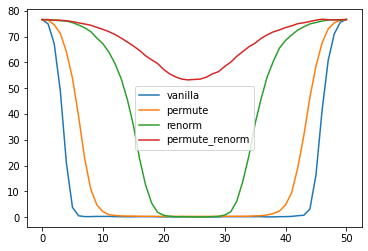

In [30]:
for k in stats.keys():
    cc = [b[2] for b in stats[k]]
    plt.plot(cc, label=k)
plt.legend()
plt.show()

## viz filters

In [10]:
def viz(w):
    w = w.detach().cpu()
    w = (w + 0.5) / 1.0
    w = w.clip(0, 1)
    
    if len(w.shape) == 3:
        w = w.unsqueeze(0)
    if w.shape[0] > 1:
        w = torchvision.utils.make_grid(w)
    else:
        w = w.squeeze(0)
    w = w.permute(1, 2, 0)
    plt.figure(figsize=(10, 10))
    plt.imshow(w)
    plt.axis('off')
    plt.show()

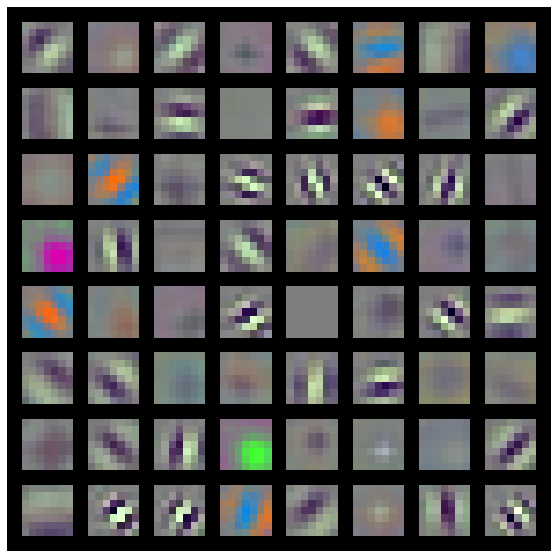

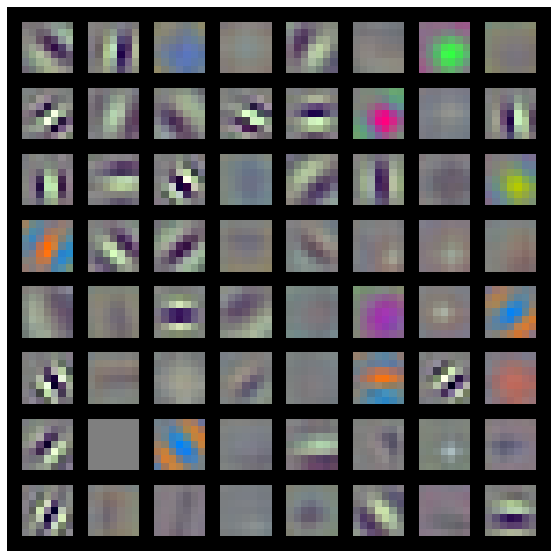

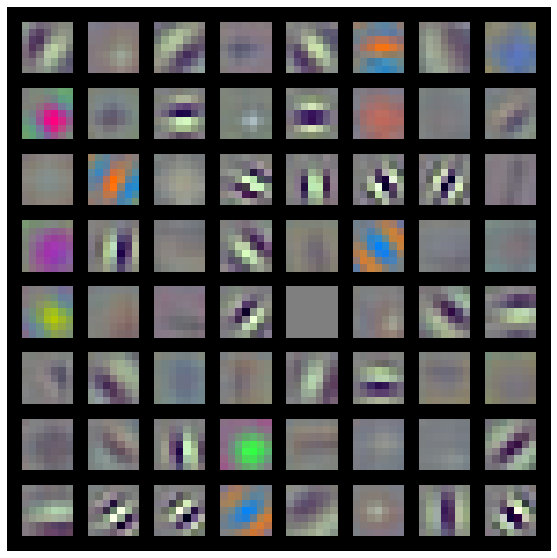

In [17]:
model = resnet50()
load_model(model, 'imagenet/resnet50_v1')
w1 = model.conv1.weight.data.clone()
viz(model.conv1.weight)
load_model(model, 'imagenet/resnet50_v2')
w2 = model.conv1.weight.data.clone()
viz(model.conv1.weight)

model = add_junctures(model)
load_model(model, 'imagenet/resnet50j_v2_perm1')
w3 = model.conv1.weight.data.clone()
viz(model.conv1.weight)

In [19]:
w3.shape

torch.Size([64, 3, 7, 7])

In [22]:
obj = {
    'v1': w1,
    'v2': w2,
    'v2_perm1': w3,
}
torch.save(obj, 'figure_objects/resnet50_filters.pt')

## extra correction

In [116]:
# class ResetLayer(nn.Module):
#     def __init__(self, layer, dim=None):
#         super().__init__()
#         self.layer = layer
#         if dim is None:
#             dim = len(layer.weight)
#         self.bn = nn.BatchNorm2d(dim)
#         self.rescale = False
        
#     def set_stats(self, goal_mean, goal_var):
#         self.bn.bias.data = goal_mean
#         goal_std = (goal_var + 1e-5).sqrt()
#         self.bn.weight.data = goal_std
        
#     def forward(self, x):
#         x = self.layer(x)
#         x1 = self.bn(x)
#         return x1 if self.rescale else x

class ResetLayer(nn.Module):
    def __init__(self, layer, dim=None, one_d=False):
        super().__init__()
        self.layer = layer
        if dim is None:
            dim = len(layer.weight)
        if one_d:
            self.bn = nn.BatchNorm1d(dim)
        else:
            self.bn = nn.BatchNorm2d(dim)
        self.rescale = False
        
    def set_stats(self, goal_mean, goal_var):
        self.bn.bias.data = goal_mean
        goal_std = (goal_var + 1e-5).sqrt()
        self.bn.weight.data = goal_std
        
    def forward(self, x):
        x = self.layer(x)
        x1 = self.bn(x)
        return x1 if self.rescale else x
    
def make_tracked_net(net):
    net1 = add_junctures(resnet50())
    net1.load_state_dict(net.state_dict())
    for i, dim in enumerate([256, 512, 1024, 2048]):
        layer = getattr(net1, 'layer%d' % (i+1))
        for j, block in enumerate(layer):
            layer[j] = ResetLayer(block, dim)
            
    net1.fc = ResetLayer(net1.fc, one_d=True)
    return net1.cuda().eval()

In [121]:
model_a = add_junctures(resnet50())
mix_weights(model_a, 0.5, 'imagenet/resnet50j_v1', 'imagenet/resnet50j_v2_perm1')
reset_bn_stats(model_a)

full_eval(model_a)

(61.980000000000004, 1.758360333442688, 53.339999999999996, 2.145424566268921)

In [131]:
model0 = add_junctures(resnet50())
model_a = add_junctures(resnet50())
model1 = add_junctures(resnet50())

k0 = 'imagenet/resnet50j_v1'
k1 = 'imagenet/resnet50j_v2_perm1'
mix_weights(model0, 0.0, k0, k1)
mix_weights(model_a, 0.5, k0, k1)
mix_weights(model1, 1.0, k0, k1)

# print('train_acc, train_loss, test_acc, test_loss...')
# print('(α=0.0)', full_eval(model0))
# print('(α=0.5)', full_eval(model_a))
# print('(α=1.0)', full_eval(model1))
evaluate(model_a)

0.0028

In [119]:
## calculate the statistics of every hidden unit in the endpoint networks
## this is done practically using PyTorch BatchNorm2d layers.
wrap0 = make_tracked_net(model0)
wrap1 = make_tracked_net(model1)
reset_bn_stats(wrap0)
reset_bn_stats(wrap1)

wrap_a = make_tracked_net(model_a)
## set the goal mean/std in added bns of interpolated network, and turn batch renormalization on
for m0, m_a, m1 in zip(wrap0.modules(), wrap_a.modules(), wrap1.modules()):
    if not isinstance(m0, ResetLayer):
        continue
    # get goal statistics -- interpolate the mean and std of parent networks
    mu0 = m0.bn.running_mean
    mu1 = m1.bn.running_mean
    goal_mean = (mu0 + mu1)/2
    var0 = m0.bn.running_var
    var1 = m1.bn.running_var
    goal_var = ((var0.sqrt() + var1.sqrt())/2).square()
    # set these in the interpolated bn controller
    m_a.set_stats(goal_mean, goal_var)
    # turn rescaling on
    m_a.rescale = True
    
# reset the tracked mean/var and fuse rescalings back into conv layers 
reset_bn_stats(wrap_a)
# # fuse the rescaling+shift coefficients back into conv layers
# model_b = fuse_tracked_net(wrap_a, w)

In [120]:
full_eval(wrap_a)

(66.18, 1.3478509044647218, 56.68, 1.833977656364441)

In [128]:
model_a = add_junctures(resnet50())
alpha = 0.5
mix_weights(model_a, alpha, k0, k1)
full_eval(model_a)

(0.13999999999999999,
 6.914904670715332,
 0.27999999999999997,
 6.9122945594787595)

In [135]:
model_a = add_junctures(resnet50())

xx = np.arange(0, 1.001, 0.02)
# xx = [0.5]
bb = []
for alpha in tqdm(xx):
    mix_weights(model_a, alpha, k0, k1)
    reset_bn_stats(model_a)
    
    ## calculate the statistics of every hidden unit in the endpoint networks
    ## this is done practically using PyTorch BatchNorm2d layers.
    wrap0 = make_tracked_net(model0)
    wrap1 = make_tracked_net(model1)
    reset_bn_stats(wrap0)
    reset_bn_stats(wrap1)

    wrap_a = make_tracked_net(model_a)
    ## set the goal mean/std in added bns of interpolated network, and turn batch renormalization on
    for m0, m_a, m1 in zip(wrap0.modules(), wrap_a.modules(), wrap1.modules()):
        if not isinstance(m0, ResetLayer):
            continue
        # get goal statistics -- interpolate the mean and std of parent networks
        mu0 = m0.bn.running_mean
        mu1 = m1.bn.running_mean
        goal_mean = (mu0 + mu1)/2
        var0 = m0.bn.running_var
        var1 = m1.bn.running_var
        goal_var = ((var0.sqrt() + var1.sqrt())/2).square()
        # set these in the interpolated bn controller
        m_a.set_stats(goal_mean, goal_var)
        # turn rescaling on
        m_a.rescale = True

    # reset the tracked mean/var and fuse rescalings back into conv layers 
    reset_bn_stats(wrap_a)
    # # fuse the rescaling+shift coefficients back into conv layers
    # model_b = fuse_tracked_net(wrap_a, w)
    
    bb.append(full_eval(wrap_a))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [10:55<00:00, 12.84s/it]


In [136]:
p = 'resnet50j_imagenet_barrier50.pt'
stats = torch.load(p)
stats['permute_renorm_plus'] = bb

In [137]:
torch.save(stats, 'resnet50j_imagenet_barrier50pp.pt')

In [ ]:
# 54.72 (with blocks), 55.44 (with fc)